In [4]:
from collections import defaultdict
import os
import pickle
import random
import requests
import time
import tqdm

from IPython.core.debugger import set_trace
import numpy as np
import pandas as pd
from pytorch_ranger import Ranger
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.utils.data as td
from torch.utils.tensorboard import SummaryWriter

from utils import (EvalDataset, OUNoise, Prioritized_Buffer, get_beta, 
                   preprocess_data, to_np, hit_metric, dcg_metric)

In [5]:
data_dir = "data"
rating = "ml-1m.train.rating"

params = {
    'batch_size': 512,
    'embedding_dim': 8,
    'hidden_dim': 16,
    'N': 5, # memory size for state_repr
    'ou_noise':False,
    'value_lr': 1e-5,
    'value_decay': 1e-4,
    'policy_lr': 1e-5,
    'policy_decay': 1e-6,
    'state_repr_lr': 1e-5,
    'state_repr_decay': 1e-3,
    'log_dir': 'logs/final/',
    'gamma': 0.8,
    'min_value': -10,
    'max_value': 10,
    'soft_tau': 1e-3,
    
    'buffer_size': 1000000
}

In [38]:
# Movielens (1M) data from the https://github.com/hexiangnan/neural_collaborative_filtering
if not os.path.isdir('./data'):
    os.mkdir('./data')
    
file_path = os.path.join(data_dir, rating)
if os.path.exists(file_path):
    print("Skip loading " + file_path)
else:
    with open(file_path, "wb") as tf:
        print("Load " + file_path)
        r = requests.get("https://raw.githubusercontent.com/hexiangnan/neural_collaborative_filtering/master/Data/" + rating)
        tf.write(r.content)
        
(train_data, train_matrix, test_data, test_matrix, 
 user_num, item_num, appropriate_users) = preprocess_data(data_dir, rating)

Skip loading data\ml-1m.train.rating


## 1. Environment

In [27]:
class Env():
    def __init__(self, user_item_matrix):
        self.matrix = user_item_matrix
        self.item_count = item_num
        self.memory = np.ones([user_num, params['N']]) * item_num
        # memory is initialized as [item_num] * N for each user
        # it is padding indexes in state_repr and will result in zero embeddings

    def reset(self, user_id):
        self.user_id = user_id
        self.viewed_items = []
        self.related_items = np.argwhere(self.matrix[self.user_id] > 0)[:, 1]
        self.num_rele = len(self.related_items)
        self.nonrelated_items = np.random.choice(
            list(set(range(self.item_count)) - set(self.related_items)), self.num_rele)
        self.available_items = np.zeros(self.num_rele * 2)
        self.available_items[::2] = self.related_items
        self.available_items[1::2] = self.nonrelated_items
        
        return torch.tensor([self.user_id]), torch.tensor(self.memory[[self.user_id], :])
    
    def step(self, action, action_emb=None, buffer=None):
        initial_user = self.user_id
        initial_memory = self.memory[[initial_user], :]
        
        reward = float(to_np(action)[0] in self.related_items)
        self.viewed_items.append(to_np(action)[0])
        if reward:
            if len(action) == 1:
                # If action is a tensor, extract the scalar value
                self.memory[self.user_id] = list(self.memory[self.user_id][1:]) + [int(action.item())]
            else:
                # If action is an array or list, make sure to extract the first element correctly
                self.memory[self.user_id] = list(self.memory[self.user_id][1:]) + [int(action[0].item())]
        
        if len(self.viewed_items) == len(self.related_items):
            done = 1
        else:
            done = 0
            
        if buffer is not None:
            buffer.push(np.array([initial_user]), np.array(initial_memory), to_np(action_emb)[0], 
                        np.array([reward]), np.array([self.user_id]), self.memory[[self.user_id], :], np.array([reward]))

        return torch.tensor([self.user_id]), torch.tensor(self.memory[[self.user_id], :]), reward, done

## 2. Model

In [8]:
class Actor_DRR(nn.Module):
    def __init__(self, embedding_dim, hidden_dim):
        super().__init__()
    
        self.layers = nn.Sequential(
            nn.Linear(embedding_dim * 3, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, embedding_dim)
        )
        
        self.initialize()

    def initialize(self):
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_uniform_(layer.weight)

    def forward(self, state):
        return self.layers(state)
    
    def get_action(self, user, memory, state_repr, 
                   action_emb,
                   items=torch.tensor([i for i in range(item_num)]),
                   return_scores=False
                  ):
        state = state_repr(user, memory)
        scores = torch.bmm(state_repr.item_embeddings(items).unsqueeze(0), 
                         action_emb.T.unsqueeze(0)).squeeze(0)
        if return_scores:
            return scores, torch.gather(items, 0, scores.argmax(0))
        else:
            return torch.gather(items, 0, scores.argmax(0))

In [18]:
class Critic_DRR(nn.Module):
    def __init__(self, state_repr_dim, action_emb_dim, hidden_dim):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(state_repr_dim + action_emb_dim, hidden_dim), 
            nn.ReLU(), 
            nn.Linear(hidden_dim, 1)
        )

        self.initialize()
        
    def initialize(self):
        for layer in self.layers:
            if isinstance(action, np.ndarray):  # Check if action is a numpy array
                action = action.flatten()  # Flatten it to a 1D array if needed
            self.memory[self.user_id] = np.append(self.memory[self.user_id][1:], action)

                    
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = self.layers(x)
        return x

In [10]:
class State_Repr_Module(nn.Module):
    def __init__(self, user_num, item_num, embedding_dim, hidden_dim):
        super().__init__()
        self.user_embeddings = nn.Embedding(user_num, embedding_dim)
        self.item_embeddings = nn.Embedding(item_num+1, embedding_dim, padding_idx=int(item_num))
        self.drr_ave = torch.nn.Conv1d(in_channels=params['N'], out_channels=1, kernel_size=1)
        %
        self.initialize()
            
    def initialize(self):
        nn.init.normal_(self.user_embeddings.weight, std=0.01)
        nn.init.normal_(self.item_embeddings.weight, std=0.01)
        self.item_embeddings.weight.data[-1].zero_()
        nn.init.uniform_(self.drr_ave.weight)
        self.drr_ave.bias.data.zero_()

    def forward(self, user, memory):
        user_embedding = self.user_embeddings(user.long())

        item_embeddings = self.item_embeddings(memory.long())
        drr_ave = self.drr_ave(item_embeddings).squeeze(1)
        
        return torch.cat((user_embedding, user_embedding * drr_ave, drr_ave), 1)

In [11]:
valid_dataset = EvalDataset(
    np.array(test_data)[np.array(test_data)[:, 0] == 6039], 
    item_num, 
    test_matrix)
valid_loader = td.DataLoader(valid_dataset, batch_size=100, shuffle=False)

full_dataset = EvalDataset(np.array(test_data), item_num, test_matrix)
full_loader = td.DataLoader(full_dataset, batch_size=100, shuffle=False)

Resetting dataset
Resetting dataset


In [12]:
def run_evaluation(net, state_representation, training_env_memory, loader=valid_loader):
    hits = []
    dcgs = []
    test_env = Env(test_matrix)
    test_env.memory = training_env_memory.copy()
    user, memory = test_env.reset(int(to_np(next(iter(valid_loader))['user'])[0]))
    for batch in loader:
        action_emb = net(state_repr(user, memory))
        scores, action = net.get_action(
            batch['user'], 
            torch.tensor(test_env.memory[to_np(batch['user']).astype(int), :]), 
            state_representation, 
            action_emb,
            batch['item'].long(), 
            return_scores=True
        )
        user, memory, reward, done = test_env.step(action)

        _, ind = scores[:, 0].topk(10)
        predictions = torch.take(batch['item'], ind).cpu().numpy().tolist()
        actual = batch['item'][0].item()
        hits.append(hit_metric(predictions, actual))
        dcgs.append(dcg_metric(predictions, actual))
        
    return np.mean(hits), np.mean(dcgs)

## 3. Training

In [13]:
torch.manual_seed(2)

state_repr = State_Repr_Module(user_num, item_num, params['embedding_dim'], params['hidden_dim'])
policy_net = Actor_DRR(params['embedding_dim'], params['hidden_dim'])
value_net  = Critic_DRR(params['embedding_dim'] * 3, params['embedding_dim'], params['hidden_dim'])
replay_buffer = Prioritized_Buffer(params['buffer_size'])

target_value_net  = Critic_DRR(params['embedding_dim'] * 3, params['embedding_dim'], params['hidden_dim'])
target_policy_net = Actor_DRR(params['embedding_dim'], params['hidden_dim'])

for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
    target_param.data.copy_(param.data)

for target_param, param in zip(target_policy_net.parameters(), policy_net.parameters()):
    target_param.data.copy_(param.data)

value_criterion  = nn.MSELoss()
value_optimizer  = Ranger(value_net.parameters(),  lr=params['value_lr'], 
                          weight_decay=params['value_decay'])
policy_optimizer = Ranger(policy_net.parameters(), lr=params['policy_lr'], 
                          weight_decay=params['policy_decay'])
state_repr_optimizer = Ranger(state_repr.parameters(), lr=params['state_repr_lr'], 
                              weight_decay=params['state_repr_decay'])

writer = SummaryWriter(log_dir=params['log_dir'])

In [14]:
def ddpg_update(training_env, 
                step=0,
                batch_size=params['batch_size'], 
                gamma=params['gamma'],
                min_value=params['min_value'],
                max_value=params['max_value'],
                soft_tau=params['soft_tau'],
               ):
    beta = get_beta(step)
    user, memory, action, reward, next_user, next_memory, done = replay_buffer.sample(batch_size, beta)
    user        = torch.FloatTensor(user)
    memory      = torch.FloatTensor(memory)
    action      = torch.FloatTensor(action)
    reward      = torch.FloatTensor(reward)
    next_user   = torch.FloatTensor(next_user)
    next_memory = torch.FloatTensor(next_memory)
    done = torch.FloatTensor(done)
    
    state       = state_repr(user, memory)
    policy_loss = value_net(state, policy_net(state))
    policy_loss = -policy_loss.mean()
    
    next_state     = state_repr(next_user, next_memory)
    next_action    = target_policy_net(next_state)
    target_value   = target_value_net(next_state, next_action.detach())
    expected_value = reward + (1.0 - done) * gamma * target_value
    expected_value = torch.clamp(expected_value, min_value, max_value)

    value = value_net(state, action)
    value_loss = value_criterion(value, expected_value.detach())
    
    state_repr_optimizer.zero_grad()
    policy_optimizer.zero_grad()
    policy_loss.backward(retain_graph=True)
    policy_optimizer.step()

    value_optimizer.zero_grad()
    value_loss.backward(retain_graph=True)
    value_optimizer.step()
    state_repr_optimizer.step()

    for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
                target_param.data.copy_(
                    target_param.data * (1.0 - soft_tau) + param.data * soft_tau
                )

    for target_param, param in zip(target_policy_net.parameters(), policy_net.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - soft_tau) + param.data * soft_tau
            )

    writer.add_histogram('value', value, step)
    writer.add_histogram('target_value', target_value, step)
    writer.add_histogram('expected_value', expected_value, step)
    writer.add_histogram('policy_loss', policy_loss, step)

In [28]:
np.random.seed(16) 

train_env = Env(train_matrix)
hits, dcgs = [], []
hits_all, dcgs_all = [], []
step, best_step = 0, 0
step, best_step, best_step_all = 0, 0, 0
users = np.random.permutation(appropriate_users)
ou_noise = OUNoise(params['embedding_dim'], decay_period=10)

# Loop through each user in the shuffled user list.
for u in tqdm.tqdm(users):
    # Reset the environment for the current user.
    user, memory = train_env.reset(u)
    if params['ou_noise']:
        ou_noise.reset()

    # Loop through each step for the current user based on their training data.
    for t in range(int(train_matrix[u].sum())):
        # Get the action embedding from the policy network based on the user's state and memory.
        action_emb = policy_net(state_repr(user, memory))

        # Add noise to the action embedding if OU noise is enabled.
        if params['ou_noise']:
            action_emb = ou_noise.get_action(action_emb.detach().cpu().numpy()[0], t)

        # Get the final action using the policy network and available items.
        action = action.flatten() 
        action = policy_net.get_action(
            user,
            torch.tensor(train_env.memory[to_np(user).astype(int), :]),
            state_repr,
            action_emb,
            torch.tensor(
                [item for item in train_env.available_items 
                 if item not in train_env.viewed_items]
            ).long()
        )

        # Take the action in the environment and observe the next state, reward, and whether it's done.
        user, memory, reward, done = train_env.step(
            action,
            action_emb,
            buffer=replay_buffer
        )

        # Perform a DDPG update if there are enough samples in the replay buffer.
        if len(replay_buffer) > params['batch_size']:
            ddpg_update(train_env, step=step)

        # Periodically evaluate the policy and log the metrics.
        if step % 100 == 0 and step > 0:
            hit, dcg = run_evaluation(policy_net, state_repr, train_env.memory)
            writer.add_scalar('hit', hit, step)  # Log hit rate to TensorBoard.
            writer.add_scalar('dcg', dcg, step)  # Log DCG to TensorBoard.
            hits.append(hit)
            dcgs.append(dcg)

            # Save the best models based on evaluation metrics.
            if np.mean(np.array([hit, dcg]) - np.array([hits[best_step], dcgs[best_step]])) > 0:
                best_step = step // 100
                torch.save(policy_net.state_dict(), params['log_dir'] + 'policy_net.pth')
                torch.save(value_net.state_dict(), params['log_dir'] + 'value_net.pth')
                torch.save(state_repr.state_dict(), params['log_dir'] + 'state_repr.pth')

        # Perform a full evaluation and save the best models periodically
        if step % 10000 == 0 and step > 0:
            hit, dcg = run_evaluation(policy_net, state_repr, train_env.memory, full_loader)
            writer.add_scalar('hit_all', hit, step)
            writer.add_scalar('dcg_all', dcg, step)
            hits_all.append(hit)
            dcgs_all.append(dcg)

            # Save the best models based on global evaluation metrics.
            if np.mean(np.array([hit, dcg]) - np.array([hits_all[best_step_all], dcgs_all[best_step_all]])) > 0:
                best_step_all = step // 10000
                torch.save(policy_net.state_dict(), params['log_dir'] + 'best_policy_net.pth')
                torch.save(value_net.state_dict(), params['log_dir'] + 'best_value_net.pth')
                torch.save(state_repr.state_dict(), params['log_dir'] + 'best_state_repr.pth')

        step += 1


  0%|          | 0/4699 [00:00<?, ?it/s]

  0%|          | 5/4699 [00:01<29:45,  2.63it/s]C:\Users\USER\AppData\Local\Temp\ipykernel_16648\2333274981.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:277.)
  action      = torch.FloatTensor(action)
c:\Users\USER\anaconda3\Lib\site-packages\pytorch_ranger\ranger.py:172: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at ..\torch\csrc\utils\python_arg_parser.cpp:1578.)
  exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
100%|██████████| 4699/4699 [11:17:45<00:00,  8.65s/it]    


In [29]:
torch.save(policy_net.state_dict(), params['log_dir'] + 'policy_net_final.pth')
torch.save(value_net.state_dict(), params['log_dir'] + 'value_net_final.pth')
torch.save(state_repr.state_dict(), params['log_dir'] + 'state_repr_final.pth')

In [30]:
# we need memory for validation, so it's better to save it and not wait next time 
with open('logs/memory.pickle', 'wb') as f:
    pickle.dump(train_env.memory, f)
    
with open('logs/memory.pickle', 'rb') as f:
    memory = pickle.load(f)

## 4. Results

In [32]:
no_ou_state_repr = State_Repr_Module(user_num, item_num, params['embedding_dim'], params['hidden_dim'])
no_ou_policy_net = Actor_DRR(params['embedding_dim'], params['hidden_dim'])
no_ou_state_repr.load_state_dict(torch.load('logs/final/' + 'best_state_repr.pth'))
no_ou_policy_net.load_state_dict(torch.load('logs/final/' + 'best_policy_net.pth'))
    
hit, dcg = run_evaluation(no_ou_policy_net, no_ou_state_repr, memory, full_loader)
print('hit rate: ', hit, 'dcg: ', dcg)

hit rate:  0.47702049133731556 dcg:  0.2594634579408827


In [33]:
ou_state_repr = State_Repr_Module(user_num, item_num, params['embedding_dim'], params['hidden_dim'])
ou_policy_net = Actor_DRR(params['embedding_dim'], params['hidden_dim'])
ou_state_repr.load_state_dict(torch.load('logs/final/' + 'best_state_repr.pth'))
ou_policy_net.load_state_dict(torch.load('logs/final/' + 'best_policy_net.pth'))

hit, dcg = run_evaluation(ou_policy_net, ou_state_repr, memory, full_loader)
print('hit rate: ', hit, 'dcg: ', dcg)

hit rate:  0.47702049133731556 dcg:  0.2594634579408827


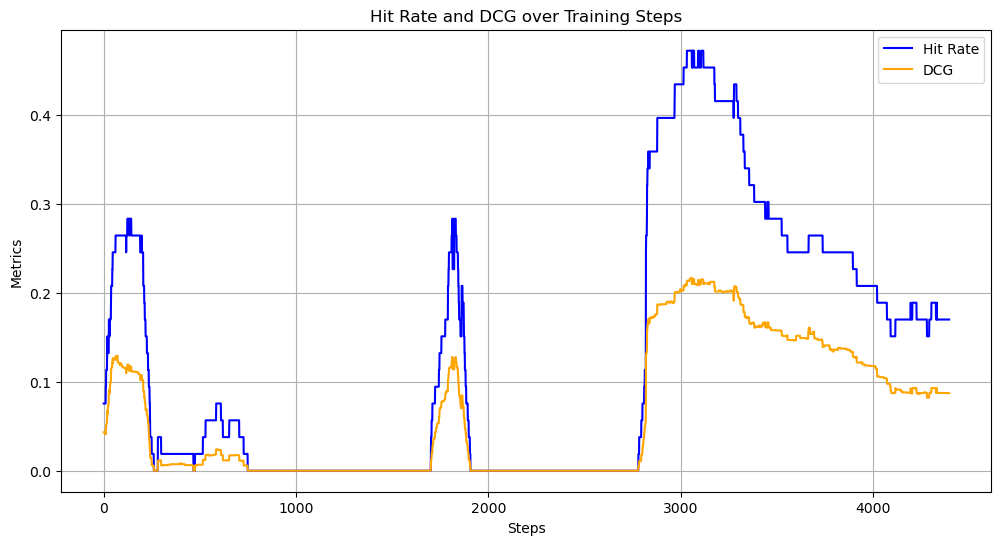

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Example: Hit Rate and DCG Over Steps
steps = np.arange(len(hits))
plt.figure(figsize=(12, 6))
plt.plot(steps, hits, label='Hit Rate', color='blue')
plt.plot(steps, dcgs, label='DCG', color='orange')
plt.xlabel('Steps')
plt.ylabel('Metrics')
plt.title('Hit Rate and DCG over Training Steps')
plt.legend()
plt.grid()
plt.show()



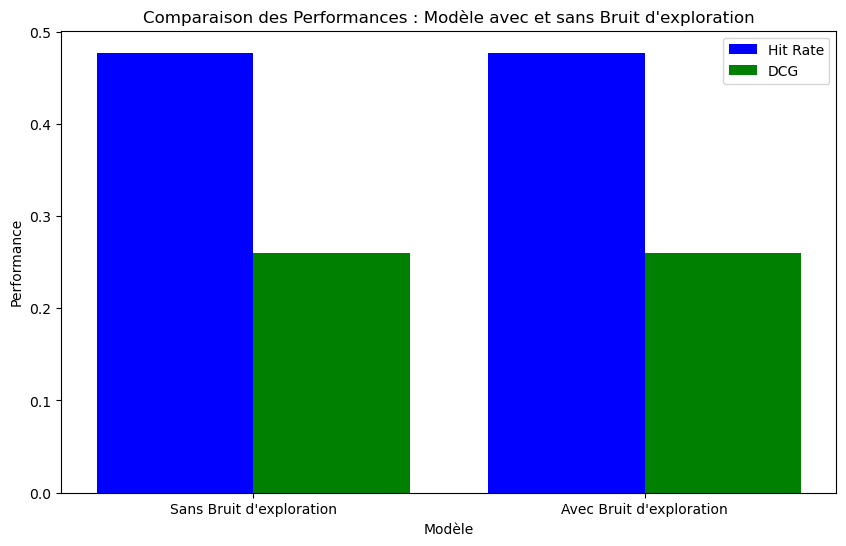

In [48]:

models = ['Sans Bruit d\'exploration', 'Avec Bruit d\'exploration']
hit_rates = [0.47702049133731556, 0.47702049133731556] 
dcgs = [0.2594634579408827, 0.2594634579408827]  

x = np.arange(len(models))  


plt.figure(figsize=(10, 6))

plt.bar(x - 0.2, hit_rates, 0.4, label='Hit Rate', color='b')

plt.bar(x + 0.2, dcgs, 0.4, label='DCG', color='g')

plt.xlabel('Modèle')
plt.ylabel('Performance')
plt.title('Comparaison des Performances : Modèle avec et sans Bruit d\'exploration')
plt.xticks(x, models)
plt.legend()

plt.show()


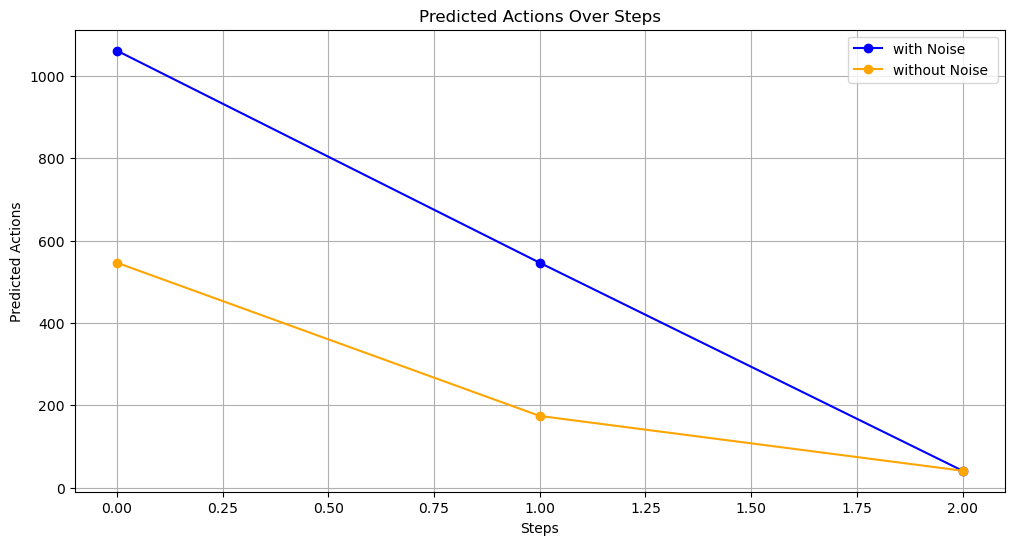

In [50]:
steps = np.arange(len(predictions[0]))  # Suppose que chaque modèle produit 3 étapes de prédictions

plt.figure(figsize=(12, 6))
plt.plot(steps, predictions[0], marker='o', label='with Noise ', color='blue')
plt.plot(steps, predictions[1], marker='o', label='without Noise ', color='orange')
plt.xlabel('Steps')
plt.ylabel('Predicted Actions')
plt.title('Predicted Actions Over Steps')
plt.legend()
plt.grid()
plt.show()


### Example of trained agents behaviour

In [34]:
random_user = np.random.randint(user_num)
print(random_user)

4906


In [36]:
movies = pd.read_csv(
    'data/movies.dat', 
    sep='::', 
    header=None, 
    engine='python', 
    names=['id', 'name', 'genre'], 
    encoding='latin-1'  # or try 'ISO-8859-1'
)

#movies = pd.read_csv('data/movies.dat', sep='::', header=None, engine='python', names=['id', 'name', 'genre'])
# in the code numeration starts with 0
movies[movies['id'].isin(np.argwhere(test_matrix[random_user] > 0)[:, 1] + 1)]

,id,name,genre
41,42,Dead Presidents (1995),Action|Crime|Drama
151,153,Batman Forever (1995),Action|Adventure|Comedy|Crime
342,346,Backbeat (1993),Drama|Musical
444,448,Fearless (1993),Drama
543,547,Surviving the Game (1994),Action|Adventure|Thriller
557,561,Killer (Bulletproof Heart) (1994),Thriller
764,774,Wend Kuuni (God's Gift) (1982),Drama
2379,2448,Virus (1999),Horror|Sci-Fi


For example we can recommend "Nixon" and "Love Serenade" and see next 3 predictions.

In [ ]:
predictions = []

for model, state_representation in zip([ou_policy_net, no_ou_policy_net], [ou_state_repr, no_ou_state_repr]):
    example_env = Env(test_matrix)
    user, memory = example_env.reset(random_user)

    user, memory, reward, _ = example_env.step(torch.tensor([13]))
    user, memory, reward, _ = example_env.step(torch.tensor([1584]))
    preds = []
    for _ in range(3):
        action_emb = model(state_representation(user, memory))
        action = model.get_action(
            user, 
            torch.tensor(example_env.memory[to_np(user).astype(int), :]), 
            state_representation, 
            action_emb,
            torch.tensor(
                [item for item in example_env.available_items 
                if item not in example_env.viewed_items]
            ).long()
        )
        user, memory, reward, _ = example_env.step(action)
        preds.append(action)

    predictions.append(preds)

print(predictions[0])
print(predictions[1])

[tensor([1061]), tensor([546]), tensor([41])]
[tensor([546]), tensor([174]), tensor([41])]


both models seems to be reasonable

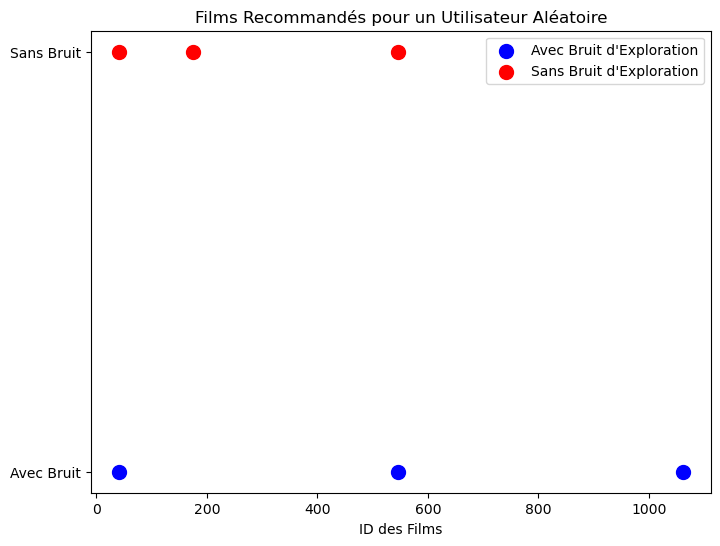

In [49]:
# Films recommandés par chaque modèle
films_avec_bruit = [1061, 546, 41]
films_sans_bruit = [546, 174, 41]

# Configuration du graphique
fig, ax = plt.subplots(figsize=(8, 6))

# Recommandations du modèle avec bruit d'exploration
ax.scatter(films_avec_bruit, [1]*len(films_avec_bruit), color='b', label='Avec Bruit d\'Exploration', s=100)

# Recommandations du modèle sans bruit d'exploration
ax.scatter(films_sans_bruit, [2]*len(films_sans_bruit), color='r', label='Sans Bruit d\'Exploration', s=100)

# Labels et titre
ax.set_xlabel('ID des Films')
ax.set_yticks([1, 2])
ax.set_yticklabels(['Avec Bruit', 'Sans Bruit'])
ax.set_title('Films Recommandés pour un Utilisateur Aléatoire')
ax.legend()

plt.show()
